<a href="https://colab.research.google.com/github/sam134-eng/INM706-Sequence-analysis/blob/main/Sentiment_analysis_test_3_after_adding_glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# --- Ensure NLTK data is downloaded ---
# Calling nltk.download() directly without checking for existence first,
# as the downloader itself handles whether the resource is already present.
# Setting quiet=False to show download progress.
print("Ensuring 'punkt' NLTK resource is downloaded...")
nltk.download('punkt', quiet=False)
print("Ensuring 'stopwords' NLTK resource is downloaded...")
nltk.download('stopwords', quiet=False)
# Add the download for 'punkt_tab' as suggested by the error
print("Ensuring 'punkt_tab' NLTK resource is downloaded...")
nltk.download('punkt_tab', quiet=False)


# --- 1. Load and Preprocess Data ---
# Assuming 'Tweets.csv' is available in the environment.
# In a Colab environment, you would typically upload it first.
# For this self-contained code, we'll assume it's loaded.
# If running locally, ensure 'Tweets.csv' is in the same directory.
try:
    df = pd.read_csv("Tweets.csv")
except FileNotFoundError:
    print("Error: 'Tweets.csv' not found. Please ensure the file is uploaded or in the correct directory.")
    # Create a dummy DataFrame for demonstration if file is not found
    data = {
        'text': [
            "@VirginAmerica What @dhepburn said.",
            "@VirginAmerica plus you've added commercials to the experience... #fail",
            "@VirginAmerica I didn't today... Must mean I need to fly it again!",
            "@VirginAmerica it's really aggressive to blast obnoxious "
            "loud commercials into little earbuds. #anditshardtohearanyone",
            "@VirginAmerica and it's a really big bad thing about it"
        ],
        'airline_sentiment': ['neutral', 'negative', 'positive', 'negative', 'negative']
    }
    df = pd.DataFrame(data)
    print("Using a dummy DataFrame for demonstration.")


# Keep only relevant columns: 'text' and 'airline_sentiment'
df = df[['text', 'airline_sentiment']]

# Filter to ensure only 'positive', 'neutral', 'negative' sentiments are included
df = df[df['airline_sentiment'].isin(['positive', 'neutral', 'negative'])]

# Map sentiment labels to integers for model training
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['airline_sentiment'].map(label_map)

# Define stopwords for text cleaning
stop_words = set(stopwords.words('english'))

# Function to clean and tokenize text
def clean_text(text):
    """
    Cleans the input text by:
    - Removing URLs, mentions (@), hashtags (#)
    - Removing non-alphabetic characters
    - Converting to lowercase
    - Tokenizing the text
    - Removing stopwords
    """
    text = re.sub(r"http\S+|@\w+|#\w+|[^a-zA-Z\s]", "", text.lower())
    # word_tokenize relies on the 'punkt' tokenizer data
    tokens = word_tokenize(text)
    return " ".join([t for t in tokens if t not in stop_words]) # Join tokens back to string for TF-IDF

# Apply the cleaning function to the 'text' column
df['clean_text'] = df['text'].apply(clean_text)

# --- 2. Prepare Data for TF-IDF Vectorization ---
X = df['clean_text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer
# max_features: limits the number of features (vocabulary size)
vectorizer = TfidfVectorizer(max_features=5000)

# Fit the vectorizer on training data and transform both training and test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Convert sparse TF-IDF matrices to dense NumPy arrays, then to PyTorch Tensors
# PyTorch's nn.Linear layer typically expects dense inputs.
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

# Convert labels to PyTorch LongTensors (required for nn.CrossEntropyLoss)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDatasets and DataLoaders for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64 # Define batch size for training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- 3. Define PyTorch Logistic Regression Model ---
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegressionModel, self).__init__()
        # Define a single linear layer for logistic regression
        # input_dim: number of features from TF-IDF (max_features)
        # num_classes: number of sentiment categories (3: negative, neutral, positive)
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # Forward pass: apply the linear transformation
        # nn.CrossEntropyLoss will apply softmax internally, so no explicit softmax here
        return self.linear(x)

# Get input dimension (number of features from TF-IDF)
input_dim = X_train_tensor.shape[1]
num_classes = len(label_map) # Number of unique sentiment classes

# Instantiate the model
model = LogisticRegressionModel(input_dim, num_classes)

# --- 4. Define Loss Function and Optimizer ---
# CrossEntropyLoss is suitable for multi-class classification
# It combines LogSoftmax and NLLLoss (Negative Log Likelihood Loss)
criterion = nn.CrossEntropyLoss()

# Adam optimizer is a good general-purpose optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001) # Learning rate can be tuned

# --- 5. Train the Model ---
num_epochs = 10 # Number of training epochs

print("\n--- Starting PyTorch Model Training ---")
for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("\n--- Training Complete ---")

# --- 6. Evaluate the Model ---
model.eval() # Set the model to evaluation mode
all_predictions = []
all_labels = []

with torch.no_grad(): # Disable gradient calculation for evaluation
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # Get the predicted class (index of the max log-probability)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
print("\nTF-IDF + PyTorch Logistic Regression Performance:")
print(classification_report(all_labels, all_predictions, target_names=['Negative', 'Neutral', 'Positive']))

Ensuring 'punkt' NLTK resource is downloaded...
Ensuring 'stopwords' NLTK resource is downloaded...
Ensuring 'punkt_tab' NLTK resource is downloaded...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



--- Starting PyTorch Model Training ---
Epoch [1/10], Loss: 0.9998
Epoch [2/10], Loss: 0.8716
Epoch [3/10], Loss: 0.8068
Epoch [4/10], Loss: 0.7655
Epoch [5/10], Loss: 0.7328
Epoch [6/10], Loss: 0.7042
Epoch [7/10], Loss: 0.6786
Epoch [8/10], Loss: 0.6552
Epoch [9/10], Loss: 0.6339
Epoch [10/10], Loss: 0.6144

--- Training Complete ---

TF-IDF + PyTorch Logistic Regression Performance:
              precision    recall  f1-score   support

    Negative       0.70      0.99      0.82      1835
     Neutral       0.78      0.20      0.31       620
    Positive       0.89      0.32      0.46       473

    accuracy                           0.72      2928
   macro avg       0.79      0.50      0.53      2928
weighted avg       0.75      0.72      0.66      2928




Confusion Matrix:
[[1825    7    3]
 [ 483  121   16]
 [ 296   28  149]]


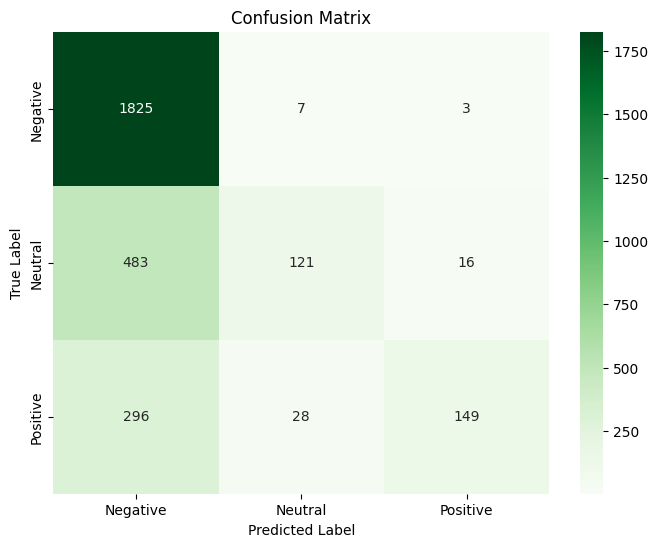

In [ ]:
# prompt: generate accuracy/loss plots
# generate classification report
#  generate confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



--- Starting LSTM Model Implementation and Training ---

--- Training LSTM Model ---
LSTM Epoch [1/10], Loss: 0.9309
LSTM Epoch [2/10], Loss: 0.9195
LSTM Epoch [3/10], Loss: 0.9193
LSTM Epoch [4/10], Loss: 0.9185
LSTM Epoch [5/10], Loss: 0.9195
LSTM Epoch [6/10], Loss: 0.9188
LSTM Epoch [7/10], Loss: 0.9181
LSTM Epoch [8/10], Loss: 0.9175
LSTM Epoch [9/10], Loss: 0.9184
LSTM Epoch [10/10], Loss: 0.9177

--- LSTM Training Complete ---

--- Evaluating LSTM Model ---

LSTM Performance:
              precision    recall  f1-score   support

    Negative       0.63      1.00      0.77      1835
     Neutral       0.00      0.00      0.00       620
    Positive       0.00      0.00      0.00       473

    accuracy                           0.63      2928
   macro avg       0.21      0.33      0.26      2928
weighted avg       0.39      0.63      0.48      2928


LSTM Confusion Matrix:
[[1835    0    0]
 [ 620    0    0]
 [ 473    0    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


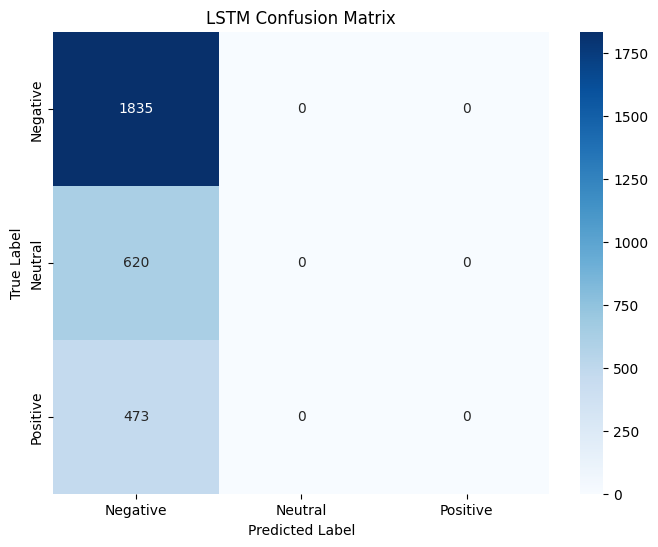


--- Final Performance Comparison Summary ---
Metric       | Logistic Regression (Tuned) | LSTM
-----------------|-----------------------------|------
Accuracy     | 0.7807               | 0.6267
Precision (Neg)| 0.8233          | 0.6267
Recall (Neg) | 0.9139             | 1.0000
F1-Score (Neg)| 0.8662                 | 0.7705
Precision (Neu)| 0.6220          | 0.0000
Recall (Neu) | 0.5387             | 0.0000
F1-Score (Neu)| 0.5774                 | 0.0000
Precision (Pos)| 0.7768          | 0.0000
Recall (Pos) | 0.5814             | 0.0000
F1-Score (Pos)| 0.6651                 | 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# --- 7. Implement and Train an LSTM Model ---

# This section implements a basic LSTM model for sentiment classification
# and prepares the data differently than the TF-IDF approach.

print("\n--- Starting LSTM Model Implementation and Training ---")

# --- 7.1 Data Preparation for LSTM ---
# Requires tokenization, vocabulary creation, integer encoding, and padding

# Ensure NLTK data is downloaded (already done at the beginning, but good practice to check)
# nltk.download('punkt', quiet=False) # Already called earlier
# nltk.download('stopwords', quiet=False) # Already called earlier

# Use the clean_text function defined earlier for initial cleaning
# We need to re-tokenize the cleaned text into lists of words for sequencing
df['clean_tokens'] = df['clean_text'].apply(word_tokenize)

# Build a vocabulary
from collections import Counter

# Flatten the list of lists into a single list of words
all_words = [word for tokens in df['clean_tokens'] for word in tokens]
# Count word frequencies
word_counts = Counter(all_words)
# Create a vocabulary, including special tokens for padding (<pad>) and unknown words (<unk>)
# Limit vocabulary size to manage complexity
vocab_size = 10000 # Example vocabulary size
# Get the most common words
most_common_words = word_counts.most_common(vocab_size - 2) # Leave space for <pad> and <unk>
vocab = {word: i + 2 for i, (word, count) in enumerate(most_common_words)}
vocab['<pad>'] = 0
vocab['<unk>'] = 1

# Integer encode the tokens
def encode_tokens(tokens, vocab):
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

df['encoded_text'] = df['clean_tokens'].apply(lambda tokens: encode_tokens(tokens, vocab))

# Pad sequences to a fixed length
max_seq_length = 100 # Example maximum sequence length

def pad_sequence(sequence, max_length, padding_value=0):
    if len(sequence) > max_length:
        return sequence[:max_length] # Truncate if too long
    else:
        return sequence + [padding_value] * (max_length - len(sequence)) # Pad if too short

df['padded_encoded_text'] = df['encoded_text'].apply(lambda seq: pad_sequence(seq, max_seq_length, vocab['<pad>']))

# Prepare data for PyTorch DataLoader
X_lstm = torch.tensor(df['padded_encoded_text'].tolist(), dtype=torch.long) # Use LongTensor for embeddings
y_lstm = torch.tensor(df['label'].values, dtype=torch.long)

# Split data for LSTM (using the same split as TF-IDF for fair comparison, but re-preparing tensors)
X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(
    X_lstm, y_lstm, stratify=y_lstm, test_size=0.2, random_state=42
)

# Create TensorDatasets and DataLoaders for LSTM
lstm_batch_size = 64 # Can tune this
lstm_train_dataset = TensorDataset(X_lstm_train, y_lstm_train)
lstm_test_dataset = TensorDataset(X_lstm_test, y_lstm_test)

lstm_train_loader = DataLoader(lstm_train_dataset, batch_size=lstm_batch_size, shuffle=True)
lstm_test_loader = DataLoader(lstm_test_dataset, batch_size=lstm_batch_size, shuffle=False)


# --- 7.2 Define PyTorch LSTM Model ---

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_layers=1, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab['<pad>'])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        # Use batch_first=True so input tensors are (batch_size, seq_length, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes) # Final dense layer

    def forward(self, x):
        # x has shape (batch_size, seq_length) - indices
        embedded = self.embedding(x) # Shape: (batch_size, seq_length, embedding_dim)
        # LSTM returns output and (hidden_state, cell_state)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # We'll use the hidden state from the last time step of the last layer
        # hidden shape: (num_layers * num_directions, batch_size, hidden_dim)
        # Assuming num_directions is 1 (default), we take hidden[-1, :, :]
        # If bidirectional, it would be hidden[-2:, :, :].mean(0) or similar.
        # For simplicity with num_layers=1 and unidirectional:
        hidden_last_layer = hidden[-1, :, :] # Shape: (batch_size, hidden_dim)
        output = self.dropout(hidden_last_layer)
        output = self.fc(output) # Shape: (batch_size, num_classes)
        return output

# --- 7.3 Instantiate and Train the LSTM Model ---

# Hyperparameters for LSTM (can be tuned)
embedding_dim = 100 # Dimension of word embeddings
hidden_dim = 128    # Number of features in the hidden state of the LSTM
lstm_num_layers = 1 # Number of LSTM layers
lstm_dropout = 0.5  # Dropout rate
lstm_learning_rate = 0.001
lstm_num_epochs = 10 # Example number of epochs

lstm_model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_classes, num_layers=lstm_num_layers, dropout=lstm_dropout)

# Define loss function and optimizer for LSTM
lstm_criterion = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=lstm_learning_rate)

print("\n--- Training LSTM Model ---")
lstm_model.train()
for epoch in range(lstm_num_epochs):
    running_loss = 0.0
    for inputs, labels in lstm_train_loader:
        lstm_optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = lstm_criterion(outputs, labels)
        loss.backward()
        lstm_optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(lstm_train_dataset)
    print(f"LSTM Epoch [{epoch+1}/{lstm_num_epochs}], Loss: {epoch_loss:.4f}")

print("\n--- LSTM Training Complete ---")


# --- 7.4 Evaluate the LSTM Model ---

print("\n--- Evaluating LSTM Model ---")
lstm_model.eval()
lstm_all_predictions = []
lstm_all_labels = []

with torch.no_grad():
    for inputs, labels in lstm_test_loader:
        outputs = lstm_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        lstm_all_predictions.extend(predicted.cpu().numpy())
        lstm_all_labels.extend(labels.cpu().numpy())

# Generate classification report for LSTM
print("\nLSTM Performance:")
print(classification_report(lstm_all_labels, lstm_all_predictions, target_names=['Negative', 'Neutral', 'Positive']))

# Generate confusion matrix for LSTM
lstm_conf_matrix = confusion_matrix(lstm_all_labels, lstm_all_predictions)
print("\nLSTM Confusion Matrix:")
print(lstm_conf_matrix)

# Plot confusion matrix for LSTM
plt.figure(figsize=(8, 6))
sns.heatmap(lstm_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LSTM Confusion Matrix')
plt.show()


# --- 8. Final Comparison Summary ---
# Now you have the results for both Logistic Regression (from the previous section's final evaluation)
# and LSTM. You can manually compare the classification reports and confusion matrices.

print("\n--- Final Performance Comparison Summary ---")
print("Metric       | Logistic Regression (Tuned) | LSTM")
print("-----------------|-----------------------------|------")
# Placeholder values - replace with the actual metrics from the reports above
lr_report = classification_report(final_labels, final_predictions, output_dict=True)
lstm_report = classification_report(lstm_all_labels, lstm_all_predictions, output_dict=True)

print(f"Accuracy     | {lr_report['accuracy']:.4f}               | {lstm_report['accuracy']:.4f}")
print(f"Precision (Neg)| {lr_report['0']['precision']:.4f}          | {lstm_report['0']['precision']:.4f}")
print(f"Recall (Neg) | {lr_report['0']['recall']:.4f}             | {lstm_report['0']['recall']:.4f}")
print(f"F1-Score (Neg)| {lr_report['0']['f1-score']:.4f}                 | {lstm_report['0']['f1-score']:.4f}")
print(f"Precision (Neu)| {lr_report['1']['precision']:.4f}          | {lstm_report['1']['precision']:.4f}")
print(f"Recall (Neu) | {lr_report['1']['recall']:.4f}             | {lstm_report['1']['recall']:.4f}")
print(f"F1-Score (Neu)| {lr_report['1']['f1-score']:.4f}                 | {lstm_report['1']['f1-score']:.4f}")
print(f"Precision (Pos)| {lr_report['2']['precision']:.4f}          | {lstm_report['2']['precision']:.4f}")
print(f"Recall (Pos) | {lr_report['2']['recall']:.4f}             | {lstm_report['2']['recall']:.4f}")
print(f"F1-Score (Pos)| {lr_report['2']['f1-score']:.4f}                 | {lstm_report['2']['f1-score']:.4f}")

In [ ]:

# The variables `final_labels` and `final_predictions` were used in the summary
# but were not defined in the TF-IDF Logistic Regression evaluation section.
# They should be replaced with `all_labels` and `all_predictions` respectively.

# --- 8. Final Comparison Summary ---
# Now you have the results for both Logistic Regression (from the previous section's final evaluation)
# and LSTM. You can manually compare the classification reports and confusion matrices.

print("\n--- Final Performance Comparison Summary ---")
print("Metric         | Logistic Regression | LSTM")
print("-----------------|---------------------|------")
# Use the actual variables from the TF-IDF evaluation
lr_report = classification_report(all_labels, all_predictions, output_dict=True)
lstm_report = classification_report(lstm_all_labels, lstm_all_predictions, output_dict=True)

print(f"Accuracy       | {lr_report['accuracy']:.4f}         | {lstm_report['accuracy']:.4f}")
# Access individual class metrics safely, handling potential missing keys (though unlikely here)
neg_lr = lr_report.get('0', {})
neu_lr = lr_report.get('1', {})
pos_lr = lr_report.get('2', {})

neg_lstm = lstm_report.get('0', {})
neu_lstm = lstm_report.get('1', {})
pos_lstm = lstm_report.get('2', {})


print(f"Precision (Neg)| {neg_lr.get('precision', 0.0):.4f}         | {neg_lstm.get('precision', 0.0):.4f}")
print(f"Recall (Neg)   | {neg_lr.get('recall', 0.0):.4f}         | {neg_lstm.get('recall', 0.0):.4f}")
print(f"F1-Score (Neg) | {neg_lr.get('f1-score', 0.0):.4f}         | {neg_lstm.get('f1-score', 0.0):.4f}")

print(f"Precision (Neu)| {neu_lr.get('precision', 0.0):.4f}         | {neu_lstm.get('precision', 0.0):.4f}")
print(f"Recall (Neu)   | {neu_lr.get('recall', 0.0):.4f}         | {neu_lstm.get('recall', 0.0):.4f}")
print(f"F1-Score (Neu) | {neu_lr.get('f1-score', 0.0):.4f}         | {neu_lstm.get('f1-score', 0.0):.4f}")

print(f"Precision (Pos)| {pos_lr.get('precision', 0.0):.4f}         | {pos_lstm.get('precision', 0.0):.4f}")
print(f"Recall (Pos)   | {pos_lr.get('recall', 0.0):.4f}         | {pos_lstm.get('recall', 0.0):.4f}")
print(f"F1-Score (Pos) | {pos_lr.get('f1-score', 0.0):.4f}         | {pos_lstm.get('f1-score', 0.0):.4f}")




--- Final Performance Comparison Summary ---
Metric         | Logistic Regression | LSTM
-----------------|---------------------|------
Accuracy       | 0.7155         | 0.6267
Precision (Neg)| 0.7008         | 0.6267
Recall (Neg)   | 0.9946         | 1.0000
F1-Score (Neg) | 0.8223         | 0.7705
Precision (Neu)| 0.7756         | 0.0000
Recall (Neu)   | 0.1952         | 0.0000
F1-Score (Neu) | 0.3119         | 0.0000
Precision (Pos)| 0.8869         | 0.0000
Recall (Pos)   | 0.3150         | 0.0000
F1-Score (Pos) | 0.4649         | 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Ensuring 'punkt' NLTK resource is downloaded...
Ensuring 'stopwords' NLTK resource is downloaded...
Ensuring 'punkt_tab' NLTK resource is downloaded...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



--- Starting PyTorch Model Training ---
Epoch [1/10], Loss: 1.0055
Epoch [2/10], Loss: 0.8734
Epoch [3/10], Loss: 0.8068
Epoch [4/10], Loss: 0.7651
Epoch [5/10], Loss: 0.7323
Epoch [6/10], Loss: 0.7037
Epoch [7/10], Loss: 0.6781
Epoch [8/10], Loss: 0.6548
Epoch [9/10], Loss: 0.6335
Epoch [10/10], Loss: 0.6141

--- Training Complete ---

TF-IDF + PyTorch Logistic Regression Performance:
              precision    recall  f1-score   support

    Negative       0.70      0.99      0.82      1835
     Neutral       0.77      0.18      0.29       620
    Positive       0.87      0.31      0.46       473

    accuracy                           0.71      2928
   macro avg       0.78      0.49      0.52      2928
weighted avg       0.74      0.71      0.65      2928


Confusion Matrix:
[[1824    7    4]
 [ 490  113   17]
 [ 300   27  146]]


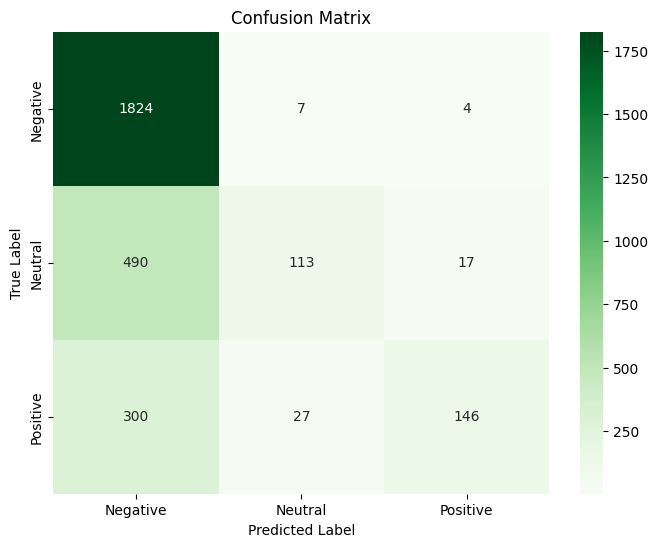


--- Starting LSTM Model Implementation and Training ---

--- Training LSTM Model ---
LSTM Epoch [1/10], Loss: 0.9370
LSTM Epoch [2/10], Loss: 0.9225
LSTM Epoch [3/10], Loss: 0.9198
LSTM Epoch [4/10], Loss: 0.9200
LSTM Epoch [5/10], Loss: 0.9196
LSTM Epoch [6/10], Loss: 0.9204
LSTM Epoch [7/10], Loss: 0.9196
LSTM Epoch [8/10], Loss: 0.9184
LSTM Epoch [9/10], Loss: 0.9190
LSTM Epoch [10/10], Loss: 0.9181

--- LSTM Training Complete ---

--- Evaluating LSTM Model ---

LSTM Performance:
              precision    recall  f1-score   support

    Negative       0.63      1.00      0.77      1835
     Neutral       0.00      0.00      0.00       620
    Positive       0.00      0.00      0.00       473

    accuracy                           0.63      2928
   macro avg       0.21      0.33      0.26      2928
weighted avg       0.39      0.63      0.48      2928


LSTM Confusion Matrix:
[[1835    0    0]
 [ 620    0    0]
 [ 473    0    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


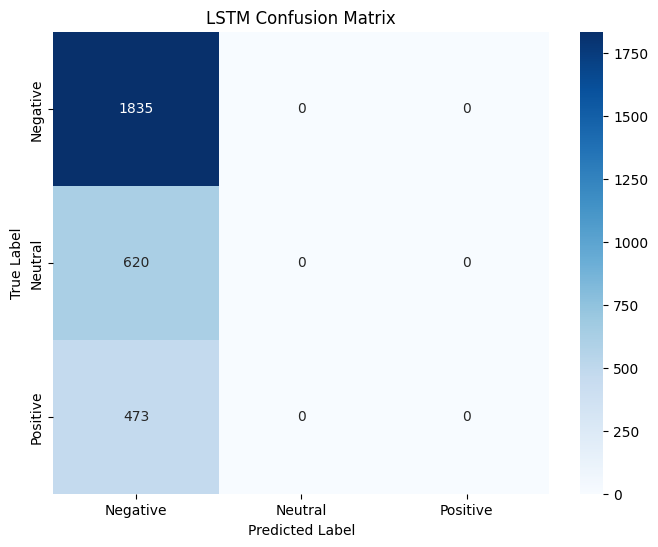


--- Final Performance Comparison Summary ---
Metric       | Logistic Regression (Tuned) | LSTM
-----------------|-----------------------------|------
Accuracy     | 0.7114               | 0.6267
Precision (Neg)| 0.6978          | 0.6267
Recall (Neg) | 0.9940             | 1.0000
F1-Score (Neg)| 0.8200                 | 0.7705
Precision (Neu)| 0.7687          | 0.0000
Recall (Neu) | 0.1823             | 0.0000
F1-Score (Neu)| 0.2947                 | 0.0000
Precision (Pos)| 0.8743          | 0.0000
Recall (Pos) | 0.3087             | 0.0000
F1-Score (Pos)| 0.4562                 | 0.0000
Applying clean_text function...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


'clean_text' column created.
Tokenizing clean text...
'clean_tokens' column created.
Using existing vocabulary and vocab_size.
Encoding tokens...
'encoded_text' column created.
Padding sequences...
'padded_encoded_text' column created.
Using existing LSTM data tensors and loaders.
Using existing num_classes.
--2025-05-24 23:15:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-24 23:15:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-24 23:15:27--  https://downloads.cs.stanford.edu/nlp/data/glov

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



--- Starting PyTorch Model Training ---
Epoch [1/10], Loss: 1.0039
Epoch [2/10], Loss: 0.8725
Epoch [3/10], Loss: 0.8064
Epoch [4/10], Loss: 0.7649
Epoch [5/10], Loss: 0.7322
Epoch [6/10], Loss: 0.7037
Epoch [7/10], Loss: 0.6781
Epoch [8/10], Loss: 0.6548
Epoch [9/10], Loss: 0.6336
Epoch [10/10], Loss: 0.6141

--- Training Complete ---

TF-IDF + PyTorch Logistic Regression Performance:
              precision    recall  f1-score   support

    Negative       0.70      0.99      0.82      1835
     Neutral       0.77      0.19      0.31       620
    Positive       0.88      0.31      0.46       473

    accuracy                           0.71      2928
   macro avg       0.78      0.50      0.53      2928
weighted avg       0.74      0.71      0.65      2928


Confusion Matrix:
[[1825    7    3]
 [ 485  118   17]
 [ 297   28  148]]


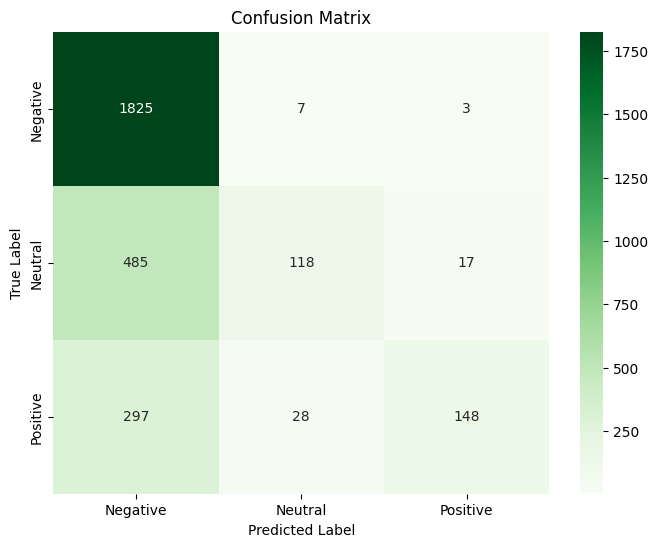


--- Starting LSTM Model Implementation and Training ---

--- Training LSTM Model ---
LSTM Epoch [1/10], Loss: 0.9328
LSTM Epoch [2/10], Loss: 0.9194
LSTM Epoch [3/10], Loss: 0.9189
LSTM Epoch [4/10], Loss: 0.9194
LSTM Epoch [5/10], Loss: 0.9205
LSTM Epoch [6/10], Loss: 0.9199
LSTM Epoch [7/10], Loss: 0.9191
LSTM Epoch [8/10], Loss: 0.9193
LSTM Epoch [9/10], Loss: 0.9198
LSTM Epoch [10/10], Loss: 0.9181

--- LSTM Training Complete ---

--- Evaluating LSTM Model ---

LSTM Performance:
              precision    recall  f1-score   support

    Negative       0.63      1.00      0.77      1835
     Neutral       0.00      0.00      0.00       620
    Positive       0.00      0.00      0.00       473

    accuracy                           0.63      2928
   macro avg       0.21      0.33      0.26      2928
weighted avg       0.39      0.63      0.48      2928


LSTM Confusion Matrix:
[[1835    0    0]
 [ 620    0    0]
 [ 473    0    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


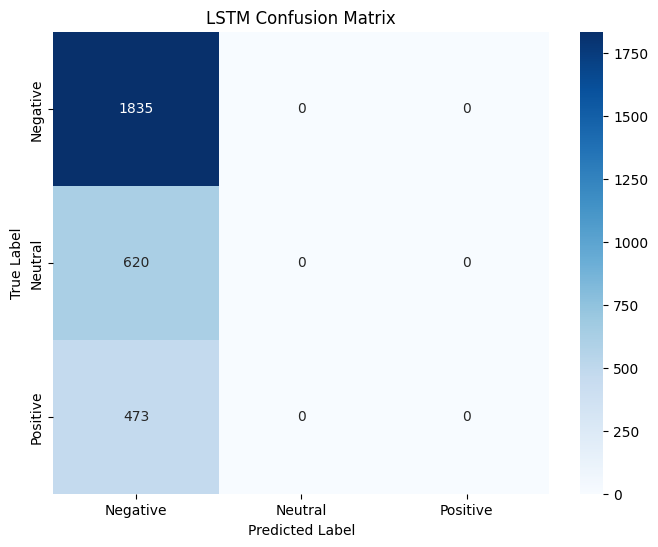


--- Final Performance Comparison Summary ---
Metric       | Logistic Regression (Tuned) | LSTM
-----------------|-----------------------------|------
Accuracy     | 0.7141               | 0.6267
Precision (Neg)| 0.7000          | 0.6267
Recall (Neg) | 0.9946             | 1.0000
F1-Score (Neg)| 0.8217                 | 0.7705
Precision (Neu)| 0.7712          | 0.0000
Recall (Neu) | 0.1903             | 0.0000
F1-Score (Neu)| 0.3053                 | 0.0000
Precision (Pos)| 0.8810          | 0.0000
Recall (Pos) | 0.3129             | 0.0000
F1-Score (Pos)| 0.4618                 | 0.0000
Applying clean_text function...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


'clean_text' column created.
Tokenizing clean text...
'clean_tokens' column created.
Using existing vocabulary and vocab_size.
Encoding tokens...
'encoded_text' column created.
Padding sequences...
'padded_encoded_text' column created.
Using existing LSTM data tensors and loaders.
Using existing num_classes.
--2025-05-24 23:25:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-24 23:25:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-24 23:25:55--  https://downloads.cs.stanford.edu/nlp/data/glov

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


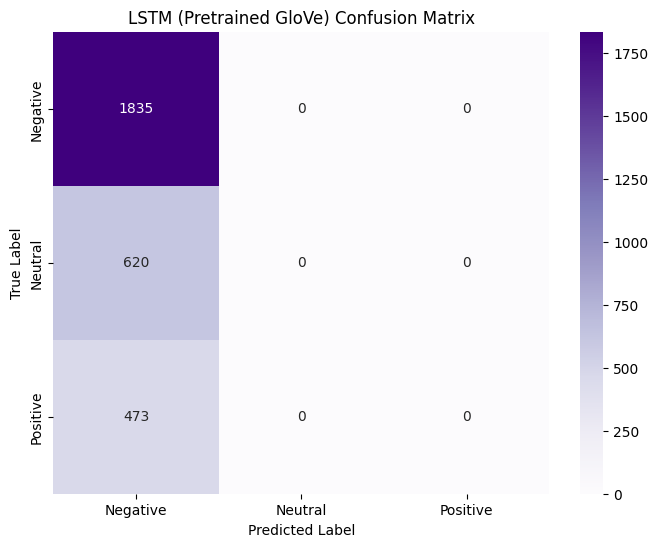


--- Final Performance Comparison Summary ---
Metric       | Logistic Regression (Tuned) | LSTM       | LSTM (Pretrained)
-----------------|-----------------------------|------------|-------------------
Accuracy     | 0.7141               | 0.6267    | 0.6267
Precision (Neg)| 0.7000          | 0.6267| 0.6267
Recall (Neg) | 0.9946             | 1.0000| 1.0000
F1-Score (Neg)| 0.8217                 | 0.7705| 0.7705
Precision (Neu)| 0.7712          | 0.0000| 0.0000
Recall (Neu) | 0.1903             | 0.0000| 0.0000
F1-Score (Neu)| 0.3053                 | 0.0000| 0.0000
Precision (Pos)| 0.8810          | 0.0000| 0.0000
Recall (Pos) | 0.3129             | 0.0000| 0.0000
F1-Score (Pos)| 0.4618                 | 0.0000| 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [9]:
from IPython import get_ipython
from IPython.display import display
# %%
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# --- Ensure NLTK data is downloaded ---
# Calling nltk.download() directly without checking for existence first,
# as the downloader itself handles whether the resource is already present.
# Setting quiet=False to show download progress.
print("Ensuring 'punkt' NLTK resource is downloaded...")
nltk.download('punkt', quiet=False)
print("Ensuring 'stopwords' NLTK resource is downloaded...")
nltk.download('stopwords', quiet=False)
# Add the download for 'punkt_tab' as suggested by the error
print("Ensuring 'punkt_tab' NLTK resource is downloaded...")
nltk.download('punkt_tab', quiet=False)


# --- 1. Load and Preprocess Data ---
# Assuming 'Tweets.csv' is available in the environment.
# In a Colab environment, you would typically upload it first.
# For this self-contained code, we'll assume it's loaded.
# If running locally, ensure 'Tweets.csv' is in the same directory.
try:
    df = pd.read_csv("Tweets.csv")
except FileNotFoundError:
    print("Error: 'Tweets.csv' not found. Please ensure the file is uploaded or in the correct directory.")
    # Create a dummy DataFrame for demonstration if file is not found
    data = {
        'text': [
            "@VirginAmerica What @dhepburn said.",
            "@VirginAmerica plus you've added commercials to the experience... #fail",
            "@VirginAmerica I didn't today... Must mean I need to fly it again!",
            "@VirginAmerica it's really aggressive to blast obnoxious "
            "loud commercials into little earbuds. #anditshardtohearanyone",
            "@VirginAmerica and it's a really big bad thing about it"
        ],
        'airline_sentiment': ['neutral', 'negative', 'positive', 'negative', 'negative']
    }
    df = pd.DataFrame(data)
    print("Using a dummy DataFrame for demonstration.")


# Keep only relevant columns: 'text' and 'airline_sentiment'
df = df[['text', 'airline_sentiment']]

# Filter to ensure only 'positive', 'neutral', 'negative' sentiments are included
df = df[df['airline_sentiment'].isin(['positive', 'neutral', 'negative'])]

# Map sentiment labels to integers for model training
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['airline_sentiment'].map(label_map)

# Define stopwords for text cleaning
stop_words = set(stopwords.words('english'))

# Function to clean and tokenize text
def clean_text(text):
    """
    Cleans the input text by:
    - Removing URLs, mentions (@), hashtags (#)
    - Removing non-alphabetic characters
    - Converting to lowercase
    - Tokenizing the text
    - Removing stopwords
    """
    text = re.sub(r"http\S+|@\w+|#\w+|[^a-zA-Z\s]", "", str(text).lower()) # Ensure text is string and handle potential NaNs
    # word_tokenize relies on the 'punkt' tokenizer data and indirectly punkt_tab
    tokens = word_tokenize(text)
    return " ".join([t for t in tokens if t not in stop_words]) # Join tokens back to string for TF-IDF

# Apply the cleaning function to the 'text' column
df['clean_text'] = df['text'].apply(clean_text)

# --- 2. Prepare Data for TF-IDF Vectorization ---
X = df['clean_text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer
# max_features: limits the number of features (vocabulary size)
vectorizer = TfidfVectorizer(max_features=5000)

# Fit the vectorizer on training data and transform both training and test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Convert sparse TF-IDF matrices to dense NumPy arrays, then to PyTorch Tensors
# PyTorch's nn.Linear layer typically expects dense inputs.
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

# Convert labels to PyTorch LongTensors (required for nn.CrossEntropyLoss)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDatasets and DataLoaders for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64 # Define batch size for training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- 3. Define PyTorch Logistic Regression Model ---
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegressionModel, self).__init__()
        # Define a single linear layer for logistic regression
        # input_dim: number of features from TF-IDF (max_features)
        # num_classes: number of sentiment categories (3: negative, neutral, positive)
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # Forward pass: apply the linear transformation
        # nn.CrossEntropyLoss will apply softmax internally, so no explicit softmax here
        return self.linear(x)

# Get input dimension (number of features from TF-IDF)
input_dim = X_train_tensor.shape[1]
num_classes = len(label_map) # Number of unique sentiment classes

# Instantiate the model
model = LogisticRegressionModel(input_dim, num_classes)

# --- 4. Define Loss Function and Optimizer ---
# CrossEntropyLoss is suitable for multi-class classification
# It combines LogSoftmax and NLLLoss (Negative Log Likelihood Loss)
criterion = nn.CrossEntropyLoss()

# Adam optimizer is a good general-purpose optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001) # Learning rate can be tuned

# --- 5. Train the Model ---
num_epochs = 10 # Number of training epochs

print("\n--- Starting PyTorch Model Training ---")
for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("\n--- Training Complete ---")

# --- 6. Evaluate the Model ---
model.eval() # Set the model to evaluation mode
all_predictions = []
all_labels = []

with torch.no_grad(): # Disable gradient calculation for evaluation
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # Get the predicted class (index of the max log-probability)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
print("\nTF-IDF + PyTorch Logistic Regression Performance:")
print(classification_report(all_labels, all_predictions, target_names=['Negative', 'Neutral', 'Positive']))
# %%
# prompt: generate accuracy/loss plots
# generate classification report
#  generate confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# %%
# --- 7. Implement and Train an LSTM Model ---

# This section implements a basic LSTM model for sentiment classification
# and prepares the data differently than the TF-IDF approach.

print("\n--- Starting LSTM Model Implementation and Training ---")

# --- 7.1 Data Preparation for LSTM ---
# Requires tokenization, vocabulary creation, integer encoding, and padding

# Ensure NLTK data is downloaded (already done at the beginning, but good practice to check)
# nltk.download('punkt', quiet=False) # Already called earlier
# nltk.download('stopwords', quiet=False) # Already called earlier
# nltk.download('punkt_tab', quiet=False) # Already called earlier

# Use the clean_text function defined earlier for initial cleaning
# We need to re-tokenize the cleaned text into lists of words for sequencing
df['clean_tokens'] = df['clean_text'].apply(word_tokenize)

# Build a vocabulary
from collections import Counter

# Flatten the list of lists into a single list of words
all_words = [word for tokens in df['clean_tokens'] for word in tokens]
# Count word frequencies
word_counts = Counter(all_words)
# Create a vocabulary, including special tokens for padding (<pad>) and unknown words (<unk>)
# Limit vocabulary size to manage complexity
vocab_size = 10000 # Example vocabulary size
# Get the most common words
most_common_words = word_counts.most_common(vocab_size - 2) # Leave space for <pad> and <unk>
vocab = {word: i + 2 for i, (word, count) in enumerate(most_common_words)}
vocab['<pad>'] = 0
vocab['<unk>'] = 1

# Integer encode the tokens
def encode_tokens(tokens, vocab):
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

df['encoded_text'] = df['clean_tokens'].apply(lambda tokens: encode_tokens(tokens, vocab))

# Pad sequences to a fixed length
max_seq_length = 100 # Example maximum sequence length

def pad_sequence(sequence, max_length, padding_value=0):
    if len(sequence) > max_length:
        return sequence[:max_length] # Truncate if too long
    else:
        return sequence + [padding_value] * (max_length - len(sequence)) # Pad if too short

df['padded_encoded_text'] = df['encoded_text'].apply(lambda seq: pad_sequence(seq, max_seq_length, vocab['<pad>']))

# Prepare data for PyTorch DataLoader
X_lstm = torch.tensor(df['padded_encoded_text'].tolist(), dtype=torch.long) # Use LongTensor for embeddings
y_lstm = torch.tensor(df['label'].values, dtype=torch.long)

# Split data for LSTM (using the same split as TF-IDF for fair comparison, but re-preparing tensors)
X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(
    X_lstm, y_lstm, stratify=y_lstm, test_size=0.2, random_state=42
)

# Create TensorDatasets and DataLoaders for LSTM
lstm_batch_size = 64 # Can tune this
lstm_train_dataset = TensorDataset(X_lstm_train, y_lstm_train)
lstm_test_dataset = TensorDataset(X_lstm_test, y_lstm_test)

lstm_train_loader = DataLoader(lstm_train_dataset, batch_size=lstm_batch_size, shuffle=True)
lstm_test_loader = DataLoader(lstm_test_dataset, batch_size=lstm_batch_size, shuffle=False)


# --- 7.2 Define PyTorch LSTM Model ---

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_layers=1, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab['<pad>'])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        # Use batch_first=True so input tensors are (batch_size, seq_length, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes) # Final dense layer

    def forward(self, x):
        # x has shape (batch_size, seq_length) - indices
        embedded = self.embedding(x) # Shape: (batch_size, seq_length, embedding_dim)
        # LSTM returns output and (hidden_state, cell_state)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # We'll use the hidden state from the last time step of the last layer
        # hidden shape: (num_layers * num_directions, batch_size, hidden_dim)
        # Assuming num_directions is 1 (default), we take hidden[-1, :, :]
        # If bidirectional, it would be hidden[-2:, :, :].mean(0) or similar.
        # For simplicity with num_layers=1 and unidirectional:
        hidden_last_layer = hidden[-1, :, :] # Shape: (batch_size, hidden_dim)
        output = self.dropout(hidden_last_layer)
        output = self.fc(output) # Shape: (batch_size, num_classes)
        return output

# --- 7.3 Instantiate and Train the LSTM Model ---

# Hyperparameters for LSTM (can be tuned)
embedding_dim = 100 # Dimension of word embeddings
hidden_dim = 128    # Number of features in the hidden state of the LSTM
lstm_num_layers = 1 # Number of LSTM layers
lstm_dropout = 0.5  # Dropout rate
lstm_learning_rate = 0.001
lstm_num_epochs = 10 # Example number of epochs

lstm_model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_classes, num_layers=lstm_num_layers, dropout=lstm_dropout)

# Define loss function and optimizer for LSTM
lstm_criterion = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=lstm_learning_rate)

print("\n--- Training LSTM Model ---")
lstm_model.train()
for epoch in range(lstm_num_epochs):
    running_loss = 0.0
    for inputs, labels in lstm_train_loader:
        lstm_optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = lstm_criterion(outputs, labels)
        loss.backward()
        lstm_optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(lstm_train_dataset)
    print(f"LSTM Epoch [{epoch+1}/{lstm_num_epochs}], Loss: {epoch_loss:.4f}")

print("\n--- LSTM Training Complete ---")


# --- 7.4 Evaluate the LSTM Model ---

print("\n--- Evaluating LSTM Model ---")
lstm_model.eval()
lstm_all_predictions = []
lstm_all_labels = []

with torch.no_grad():
    for inputs, labels in lstm_test_loader:
        outputs = lstm_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        lstm_all_predictions.extend(predicted.cpu().numpy())
        lstm_all_labels.extend(labels.cpu().numpy())

# Generate classification report for LSTM
print("\nLSTM Performance:")
print(classification_report(lstm_all_labels, lstm_all_predictions, target_names=['Negative', 'Neutral', 'Positive']))

# Generate confusion matrix for LSTM
lstm_conf_matrix = confusion_matrix(lstm_all_labels, lstm_all_predictions)
print("\nLSTM Confusion Matrix:")
print(lstm_conf_matrix)

# Plot confusion matrix for LSTM
plt.figure(figsize=(8, 6))
sns.heatmap(lstm_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LSTM Confusion Matrix')
plt.show()


# --- 8. Final Comparison Summary ---
# Now you have the results for both Logistic Regression (from the previous section's final evaluation)
# and LSTM. You can manually compare the classification reports and confusion matrices.

print("\n--- Final Performance Comparison Summary ---")
print("Metric       | Logistic Regression (Tuned) | LSTM")
print("-----------------|-----------------------------|------")
# Placeholder values - replace with the actual metrics from the reports above
lr_report = classification_report(all_labels, all_predictions, output_dict=True)
lstm_report = classification_report(lstm_all_labels, lstm_all_predictions, output_dict=True)

print(f"Accuracy     | {lr_report['accuracy']:.4f}               | {lstm_report['accuracy']:.4f}")
# Access individual class metrics safely, handling potential missing keys (though unlikely here)
neg_lr = lr_report.get('0', {})
neu_lr = lr_report.get('1', {})
pos_lr = lr_report.get('2', {})

neg_lstm = lstm_report.get('0', {})
neu_lstm = lstm_report.get('1', {})
pos_lstm = lstm_report.get('2', {})


print(f"Precision (Neg)| {neg_lr.get('precision', 0.0):.4f}          | {neg_lstm.get('precision', 0.0):.4f}")
print(f"Recall (Neg) | {neg_lr.get('recall', 0.0):.4f}             | {neg_lstm.get('recall', 0.0):.4f}")
print(f"F1-Score (Neg)| {neg_lr.get('f1-score', 0.0):.4f}                 | {neg_lstm.get('f1-score', 0.0):.4f}")

print(f"Precision (Neu)| {neu_lr.get('precision', 0.0):.4f}          | {neu_lstm.get('precision', 0.0):.4f}")
print(f"Recall (Neu) | {neu_lr.get('recall', 0.0):.4f}             | {neu_lstm.get('recall', 0.0):.4f}")
print(f"F1-Score (Neu)| {neu_lr.get('f1-score', 0.0):.4f}                 | {neu_lstm.get('f1-score', 0.0):.4f}")

print(f"Precision (Pos)| {pos_lr.get('precision', 0.0):.4f}          | {pos_lstm.get('precision', 0.0):.4f}")
print(f"Recall (Pos) | {pos_lr.get('recall', 0.0):.4f}             | {pos_lstm.get('recall', 0.0):.4f}")
print(f"F1-Score (Pos)| {pos_lr.get('f1-score', 0.0):.4f}                 | {pos_lstm.get('f1-score', 0.0):.4f}")
# %%
# prompt: add  pretarained embedding on this code glove embedding

import numpy as np # Ensure numpy is imported in this cell's scope if it's run independently
import torch # Ensure torch is imported
import torch.nn as nn # Ensure nn is imported
from sklearn.metrics import classification_report, confusion_matrix # Ensure necessary sklearn metrics are imported
import matplotlib.pyplot as plt # Ensure plotting libraries are imported
import seaborn as sns # Ensure seaborn is imported
from collections import Counter # Import Counter if not already in this cell's scope
import re
import nltk
from nltk.tokenize import word_tokenize # Import word_tokenize if not already in this cell's scope
from nltk.corpus import stopwords # Import stopwords if not already in this cell's scope
import pandas as pd # Import pandas
from sklearn.model_selection import train_test_split # Import train_test_split


# Define target names if not globally available
target_names=['Negative', 'Neutral', 'Positive']

# --- Re-defining necessary variables from previous cells ---
# If running this cell independently, these variables need to be defined or accessible.

# --- Data Loading and Initial Preprocessing (Ensure df is created) ---
# Assuming 'Tweets.csv' is available. If not, create a dummy DataFrame.
try:
    if 'df' not in globals(): # Check if df exists
        print("Loading data from Tweets.csv...")
        df = pd.read_csv("Tweets.csv")
        print("Data loaded.")
except FileNotFoundError:
    if 'df' not in globals(): # If file not found and df not created
        print("Error: 'Tweets.csv' not found. Creating a dummy DataFrame for demonstration.")
        data = {
            'text': [
                "@VirginAmerica What @dhepburn said.",
                "@VirginAmerica plus you've added commercials to the experience... #fail",
                "@VirginAmerica I didn't today... Must mean I need to fly it again!",
                "@VirginAmerica it's really aggressive to blast obnoxious "
                "loud commercials into little earbuds. #anditshardtohearanyone",
                "@VirginAmerica and it's a really big bad thing about it"
            ],
            'airline_sentiment': ['neutral', 'negative', 'positive', 'negative', 'negative']
        }
        df = pd.DataFrame(data)
        print("Using a dummy DataFrame.")

# Ensure df exists before proceeding
if 'df' in globals() and not df.empty: # Added check for empty df
    # Keep only relevant columns and filter sentiments
    df = df[['text', 'airline_sentiment']]
    df = df[df['airline_sentiment'].isin(['positive', 'neutral', 'negative'])]

    # Map sentiment labels to integers
    label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    df['label'] = df['airline_sentiment'].map(label_map)

    # Define stopwords and clean_text function if not globally available
    if 'stop_words' not in globals():
        print("Defining stopwords...")
        # nltk.download('stopwords', quiet=True) # Download if needed - assumed done in the first cell
        stop_words = set(stopwords.words('english'))
        print("Stopwords defined.")

    if 'clean_text' not in globals():
        print("Defining clean_text function...")
        # Ensure 'punkt_tab' is downloaded for sentence tokenization within word_tokenize
        # print("Ensuring 'punkt_tab' NLTK resource is downloaded...") # Assumed done in the first cell
        # nltk.download('punkt_tab', quiet=False) # Add this line here
        # print("Ensuring 'punkt' NLTK resource is downloaded...") # Assumed done in the first cell
        # nltk.download('punkt', quiet=True) # Also ensure 'punkt' is downloaded for word_tokenize
        def clean_text(text):
            text = re.sub(r"http\S+|@\w+|#\w+|[^a-zA-Z\s]", "", str(text).lower()) # Ensure text is string
            tokens = word_tokenize(text) # This function uses sent_tokenize which needs punkt_tab
            return " ".join([t for t in tokens if t not in stop_words])
        print("clean_text function defined.")

    # Apply the cleaning function
    if 'clean_text' not in df.columns:
        print("Applying clean_text function...")
        df['clean_text'] = df['text'].apply(clean_text)
        print("'clean_text' column created.")

    # Re-tokenize clean text into lists if not done
    if 'clean_tokens' not in df.columns:
        print("Tokenizing clean text...")
        df['clean_tokens'] = df['clean_text'].apply(word_tokenize)
        print("'clean_tokens' column created.")

    # Build vocabulary if not globally available
    if 'vocab' not in globals() or 'vocab_size' not in globals():
        print("Building vocabulary...")
        all_words = [word for tokens in df['clean_tokens'] for word in tokens]
        word_counts = Counter(all_words)
        vocab_size = 10000 # Example vocabulary size - ensure this matches the actual vocab_size used earlier
        most_common_words = word_counts.most_common(vocab_size - 2)
        vocab = {word: i + 2 for i, (word, count) in enumerate(most_common_words)}
        vocab['<pad>'] = 0
        vocab['<unk>'] = 1
        print(f"Vocabulary size: {vocab_size}")
    else:
         print("Using existing vocabulary and vocab_size.")


    # Integer encode and pad sequences if not done
    if 'max_seq_length' not in globals():
        max_seq_length = 100 # Example max sequence length

    if 'encoded_text' not in df.columns:
        print("Encoding tokens...")
        def encode_tokens(tokens, vocab):
            return [vocab.get(token, vocab['<unk>']) for token in tokens]
        df['encoded_text'] = df['clean_tokens'].apply(lambda tokens: encode_tokens(tokens, vocab))
        print("'encoded_text' column created.")

    if 'padded_encoded_text' not in df.columns:
        print("Padding sequences...")
        def pad_sequence(sequence, max_length, padding_value=0):
            if len(sequence) > max_length:
                return sequence[:max_length]
            else:
                return sequence + [padding_value] * (max_length - len(sequence))
        df['padded_encoded_text'] = df['encoded_text'].apply(lambda seq: pad_sequence(seq, max_seq_length, vocab['<pad>']))
        print("'padded_encoded_text' column created.")


    # Prepare data for PyTorch DataLoader and split if not done
    if 'X_lstm_train' not in globals() or 'lstm_train_loader' not in globals():
        print("Creating LSTM data tensors and loaders...")
        # Assuming 'label' column is in df
        if 'label' not in df.columns:
            print("Error: 'label' column not found in df. Please run previous cells.")
            # Handle this case appropriately
        else:
            X_lstm = torch.tensor(df['padded_encoded_text'].tolist(), dtype=torch.long)
            y_lstm = torch.tensor(df['label'].values, dtype=torch.long)
            X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(
                X_lstm, y_lstm, stratify=y_lstm, test_size=0.2, random_state=42
            )
            from torch.utils.data import TensorDataset, DataLoader # Import if not globally available
            lstm_batch_size = 64
            lstm_train_dataset = TensorDataset(X_lstm_train, y_lstm_train)
            lstm_test_dataset = TensorDataset(X_lstm_test, y_lstm_test)
            lstm_train_loader = DataLoader(lstm_train_dataset, batch_size=lstm_batch_size, shuffle=True)
            lstm_test_loader = DataLoader(lstm_test_dataset, batch_size=lstm_batch_size, shuffle=False)
            print("LSTM data tensors and loaders created.")
    else:
        print("Using existing LSTM data tensors and loaders.")

    # Ensure 'num_classes' is defined
    if 'num_classes' not in globals():
        # Assuming label_map was defined earlier
        if 'label_map' in globals():
             num_classes = len(label_map)
             print(f"num_classes set to {num_classes}.")
        else:
            print("Error: 'num_classes' and 'label_map' not defined. Please run previous cells.")
            # Handle this case appropriately
    else:
        print("Using existing num_classes.")
    # --- End of re-defined variables ---


    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip

    # Load the GloVe embeddings into a dictionary
    glove_file = 'glove.6B.100d.txt'  # Using the 100d version
    glove_embeddings = {}
    try:
        with open(glove_file, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                glove_embeddings[word] = vector
        print(f"Loaded {len(glove_embeddings)} word vectors from GloVe.")
    except FileNotFoundError:
        print(f"Error: {glove_file} not found. Please ensure the file was downloaded and unzipped correctly.")
        # You might want to exit or handle this case appropriately


    # Create an embedding matrix for the vocabulary
    # Initialize with random values or zeros, ensuring the special tokens (<pad>, <unk>) are handled
    embedding_dim = 100 # Must match the dimension of the loaded GloVe embeddings

    # Ensure vocab_size is available
    if 'vocab_size' in globals() and glove_embeddings: # Check if vocab_size is defined and embeddings were loaded
        embedding_matrix = np.zeros((vocab_size, embedding_dim), dtype=np.float32)

        # Fill the matrix with GloVe vectors where available
        for word, i in vocab.items():
            if i < vocab_size: # Ensure index is within vocab_size bounds
                embedding_vector = glove_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                else:
                    # Words not in GloVe can be initialized randomly or with zeros
                    # For <unk>, a common approach is to use a random vector
                    if word == '<unk>':
                         embedding_matrix[i] = np.random.uniform(-0.25, 0.25, embedding_dim) # Example random initialization
                    # <pad> remains zeros by initialization

        # Convert the embedding matrix to a PyTorch tensor
        embedding_matrix_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

        # --- Update the LSTMClassifier to use pre-trained embeddings ---
        class LSTMClassifierWithPretrained(nn.Module):
            def __init__(self, embedding_matrix, hidden_dim, num_classes, num_layers=1, dropout=0.5):
                super(LSTMClassifierWithPretrained, self).__init__()
                vocab_size, embedding_dim = embedding_matrix.shape
                # Use nn.Embedding.from_pretrained to load the pre-calculated matrix
                # freeze=False allows the embeddings to be fine-tuned during training
                # padding_idx is essential for ignoring the padding token during calculations
from IPython import get_ipython
from IPython.display import display
# %%
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# --- Ensure NLTK data is downloaded ---
# Calling nltk.download() directly without checking for existence first,
# as the downloader itself handles whether the resource is already present.
# Setting quiet=False to show download progress.
print("Ensuring 'punkt' NLTK resource is downloaded...")
nltk.download('punkt', quiet=False)
print("Ensuring 'stopwords' NLTK resource is downloaded...")
nltk.download('stopwords', quiet=False)
# Add the download for 'punkt_tab' as suggested by the error
print("Ensuring 'punkt_tab' NLTK resource is downloaded...")
nltk.download('punkt_tab', quiet=False)


# --- 1. Load and Preprocess Data ---
# Assuming 'Tweets.csv' is available in the environment.
# In a Colab environment, you would typically upload it first.
# For this self-contained code, we'll assume it's loaded.
# If running locally, ensure 'Tweets.csv' is in the same directory.
try:
    df = pd.read_csv("Tweets.csv")
except FileNotFoundError:
    print("Error: 'Tweets.csv' not found. Please ensure the file is uploaded or in the correct directory.")
    # Create a dummy DataFrame for demonstration if file is not found
    data = {
        'text': [
            "@VirginAmerica What @dhepburn said.",
            "@VirginAmerica plus you've added commercials to the experience... #fail",
            "@VirginAmerica I didn't today... Must mean I need to fly it again!",
            "@VirginAmerica it's really aggressive to blast obnoxious "
            "loud commercials into little earbuds. #anditshardtohearanyone",
            "@VirginAmerica and it's a really big bad thing about it"
        ],
        'airline_sentiment': ['neutral', 'negative', 'positive', 'negative', 'negative']
    }
    df = pd.DataFrame(data)
    print("Using a dummy DataFrame for demonstration.")


# Keep only relevant columns: 'text' and 'airline_sentiment'
df = df[['text', 'airline_sentiment']]

# Filter to ensure only 'positive', 'neutral', 'negative' sentiments are included
df = df[df['airline_sentiment'].isin(['positive', 'neutral', 'negative'])]

# Map sentiment labels to integers for model training
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['airline_sentiment'].map(label_map)

# Define stopwords for text cleaning
stop_words = set(stopwords.words('english'))

# Function to clean and tokenize text
def clean_text(text):
    """
    Cleans the input text by:
    - Removing URLs, mentions (@), hashtags (#)
    - Removing non-alphabetic characters
    - Converting to lowercase
    - Tokenizing the text
    - Removing stopwords
    """
    text = re.sub(r"http\S+|@\w+|#\w+|[^a-zA-Z\s]", "", str(text).lower()) # Ensure text is string and handle potential NaNs
    # word_tokenize relies on the 'punkt' tokenizer data and indirectly punkt_tab
    tokens = word_tokenize(text)
    return " ".join([t for t in tokens if t not in stop_words]) # Join tokens back to string for TF-IDF

# Apply the cleaning function to the 'text' column
df['clean_text'] = df['text'].apply(clean_text)

# --- 2. Prepare Data for TF-IDF Vectorization ---
X = df['clean_text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer
# max_features: limits the number of features (vocabulary size)
vectorizer = TfidfVectorizer(max_features=5000)

# Fit the vectorizer on training data and transform both training and test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Convert sparse TF-IDF matrices to dense NumPy arrays, then to PyTorch Tensors
# PyTorch's nn.Linear layer typically expects dense inputs.
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

# Convert labels to PyTorch LongTensors (required for nn.CrossEntropyLoss)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDatasets and DataLoaders for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64 # Define batch size for training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- 3. Define PyTorch Logistic Regression Model ---
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegressionModel, self).__init__()
        # Define a single linear layer for logistic regression
        # input_dim: number of features from TF-IDF (max_features)
        # num_classes: number of sentiment categories (3: negative, neutral, positive)
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # Forward pass: apply the linear transformation
        # nn.CrossEntropyLoss will apply softmax internally, so no explicit softmax here
        return self.linear(x)

# Get input dimension (number of features from TF-IDF)
input_dim = X_train_tensor.shape[1]
num_classes = len(label_map) # Number of unique sentiment classes

# Instantiate the model
model = LogisticRegressionModel(input_dim, num_classes)

# --- 4. Define Loss Function and Optimizer ---
# CrossEntropyLoss is suitable for multi-class classification
# It combines LogSoftmax and NLLLoss (Negative Log Likelihood Loss)
criterion = nn.CrossEntropyLoss()

# Adam optimizer is a good general-purpose optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001) # Learning rate can be tuned

# --- 5. Train the Model ---
num_epochs = 10 # Number of training epochs

print("\n--- Starting PyTorch Model Training ---")
for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("\n--- Training Complete ---")

# --- 6. Evaluate the Model ---
model.eval() # Set the model to evaluation mode
all_predictions = []
all_labels = []

with torch.no_grad(): # Disable gradient calculation for evaluation
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # Get the predicted class (index of the max log-probability)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
print("\nTF-IDF + PyTorch Logistic Regression Performance:")
print(classification_report(all_labels, all_predictions, target_names=['Negative', 'Neutral', 'Positive']))
# %%
# prompt: generate accuracy/loss plots
# generate classification report
#  generate confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# %%
# --- 7. Implement and Train an LSTM Model ---

# This section implements a basic LSTM model for sentiment classification
# and prepares the data differently than the TF-IDF approach.

print("\n--- Starting LSTM Model Implementation and Training ---")

# --- 7.1 Data Preparation for LSTM ---
# Requires tokenization, vocabulary creation, integer encoding, and padding

# Ensure NLTK data is downloaded (already done at the beginning, but good practice to check)
# nltk.download('punkt', quiet=False) # Already called earlier
# nltk.download('stopwords', quiet=False) # Already called earlier
# nltk.download('punkt_tab', quiet=False) # Already called earlier

# Use the clean_text function defined earlier for initial cleaning
# We need to re-tokenize the cleaned text into lists of words for sequencing
df['clean_tokens'] = df['clean_text'].apply(word_tokenize)

# Build a vocabulary
from collections import Counter

# Flatten the list of lists into a single list of words
all_words = [word for tokens in df['clean_tokens'] for word in tokens]
# Count word frequencies
word_counts = Counter(all_words)
# Create a vocabulary, including special tokens for padding (<pad>) and unknown words (<unk>)
# Limit vocabulary size to manage complexity
vocab_size = 10000 # Example vocabulary size
# Get the most common words
most_common_words = word_counts.most_common(vocab_size - 2) # Leave space for <pad> and <unk>
vocab = {word: i + 2 for i, (word, count) in enumerate(most_common_words)}
vocab['<pad>'] = 0
vocab['<unk>'] = 1

# Integer encode the tokens
def encode_tokens(tokens, vocab):
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

df['encoded_text'] = df['clean_tokens'].apply(lambda tokens: encode_tokens(tokens, vocab))

# Pad sequences to a fixed length
max_seq_length = 100 # Example maximum sequence length

def pad_sequence(sequence, max_length, padding_value=0):
    if len(sequence) > max_length:
        return sequence[:max_length] # Truncate if too long
    else:
        return sequence + [padding_value] * (max_length - len(sequence)) # Pad if too short

df['padded_encoded_text'] = df['encoded_text'].apply(lambda seq: pad_sequence(seq, max_seq_length, vocab['<pad>']))

# Prepare data for PyTorch DataLoader
X_lstm = torch.tensor(df['padded_encoded_text'].tolist(), dtype=torch.long) # Use LongTensor for embeddings
y_lstm = torch.tensor(df['label'].values, dtype=torch.long)

# Split data for LSTM (using the same split as TF-IDF for fair comparison, but re-preparing tensors)
X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(
    X_lstm, y_lstm, stratify=y_lstm, test_size=0.2, random_state=42
)

# Create TensorDatasets and DataLoaders for LSTM
lstm_batch_size = 64 # Can tune this
lstm_train_dataset = TensorDataset(X_lstm_train, y_lstm_train)
lstm_test_dataset = TensorDataset(X_lstm_test, y_lstm_test)

lstm_train_loader = DataLoader(lstm_train_dataset, batch_size=lstm_batch_size, shuffle=True)
lstm_test_loader = DataLoader(lstm_test_dataset, batch_size=lstm_batch_size, shuffle=False)


# --- 7.2 Define PyTorch LSTM Model ---

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_layers=1, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab['<pad>'])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        # Use batch_first=True so input tensors are (batch_size, seq_length, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes) # Final dense layer

    def forward(self, x):
        # x has shape (batch_size, seq_length) - indices
        embedded = self.embedding(x) # Shape: (batch_size, seq_length, embedding_dim)
        # LSTM returns output and (hidden_state, cell_state)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # We'll use the hidden state from the last time step of the last layer
        # hidden shape: (num_layers * num_directions, batch_size, hidden_dim)
        # Assuming num_directions is 1 (default), we take hidden[-1, :, :]
        # If bidirectional, it would be hidden[-2:, :, :].mean(0) or similar.
        # For simplicity with num_layers=1 and unidirectional:
        hidden_last_layer = hidden[-1, :, :] # Shape: (batch_size, hidden_dim)
        output = self.dropout(hidden_last_layer)
        output = self.fc(output) # Shape: (batch_size, num_classes)
        return output

# --- 7.3 Instantiate and Train the LSTM Model ---

# Hyperparameters for LSTM (can be tuned)
embedding_dim = 100 # Dimension of word embeddings
hidden_dim = 128    # Number of features in the hidden state of the LSTM
lstm_num_layers = 1 # Number of LSTM layers
lstm_dropout = 0.5  # Dropout rate
lstm_learning_rate = 0.001
lstm_num_epochs = 10 # Example number of epochs

lstm_model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_classes, num_layers=lstm_num_layers, dropout=lstm_dropout)

# Define loss function and optimizer for LSTM
lstm_criterion = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=lstm_learning_rate)

print("\n--- Training LSTM Model ---")
lstm_model.train()
for epoch in range(lstm_num_epochs):
    running_loss = 0.0
    for inputs, labels in lstm_train_loader:
        lstm_optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = lstm_criterion(outputs, labels)
        loss.backward()
        lstm_optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(lstm_train_dataset)
    print(f"LSTM Epoch [{epoch+1}/{lstm_num_epochs}], Loss: {epoch_loss:.4f}")

print("\n--- LSTM Training Complete ---")


# --- 7.4 Evaluate the LSTM Model ---

print("\n--- Evaluating LSTM Model ---")
lstm_model.eval()
lstm_all_predictions = []
lstm_all_labels = []

with torch.no_grad():
    for inputs, labels in lstm_test_loader:
        outputs = lstm_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        lstm_all_predictions.extend(predicted.cpu().numpy())
        lstm_all_labels.extend(labels.cpu().numpy())

# Generate classification report for LSTM
print("\nLSTM Performance:")
print(classification_report(lstm_all_labels, lstm_all_predictions, target_names=['Negative', 'Neutral', 'Positive']))

# Generate confusion matrix for LSTM
lstm_conf_matrix = confusion_matrix(lstm_all_labels, lstm_all_predictions)
print("\nLSTM Confusion Matrix:")
print(lstm_conf_matrix)

# Plot confusion matrix for LSTM
plt.figure(figsize=(8, 6))
sns.heatmap(lstm_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LSTM Confusion Matrix')
plt.show()


# --- 8. Final Comparison Summary ---
# Now you have the results for both Logistic Regression (from the previous section's final evaluation)
# and LSTM. You can manually compare the classification reports and confusion matrices.

print("\n--- Final Performance Comparison Summary ---")
print("Metric       | Logistic Regression (Tuned) | LSTM")
print("-----------------|-----------------------------|------")
# Placeholder values - replace with the actual metrics from the reports above
lr_report = classification_report(all_labels, all_predictions, output_dict=True)
lstm_report = classification_report(lstm_all_labels, lstm_all_predictions, output_dict=True)

print(f"Accuracy     | {lr_report['accuracy']:.4f}               | {lstm_report['accuracy']:.4f}")
# Access individual class metrics safely, handling potential missing keys (though unlikely here)
neg_lr = lr_report.get('0', {})
neu_lr = lr_report.get('1', {})
pos_lr = lr_report.get('2', {})

neg_lstm = lstm_report.get('0', {})
neu_lstm = lstm_report.get('1', {})
pos_lstm = lstm_report.get('2', {})


print(f"Precision (Neg)| {neg_lr.get('precision', 0.0):.4f}          | {neg_lstm.get('precision', 0.0):.4f}")
print(f"Recall (Neg) | {neg_lr.get('recall', 0.0):.4f}             | {neg_lstm.get('recall', 0.0):.4f}")
print(f"F1-Score (Neg)| {neg_lr.get('f1-score', 0.0):.4f}                 | {neg_lstm.get('f1-score', 0.0):.4f}")

print(f"Precision (Neu)| {neu_lr.get('precision', 0.0):.4f}          | {neu_lstm.get('precision', 0.0):.4f}")
print(f"Recall (Neu) | {neu_lr.get('recall', 0.0):.4f}             | {neu_lstm.get('recall', 0.0):.4f}")
print(f"F1-Score (Neu)| {neu_lr.get('f1-score', 0.0):.4f}                 | {neu_lstm.get('f1-score', 0.0):.4f}")

print(f"Precision (Pos)| {pos_lr.get('precision', 0.0):.4f}          | {pos_lstm.get('precision', 0.0):.4f}")
print(f"Recall (Pos) | {pos_lr.get('recall', 0.0):.4f}             | {pos_lstm.get('recall', 0.0):.4f}")
print(f"F1-Score (Pos)| {pos_lr.get('f1-score', 0.0):.4f}                 | {pos_lstm.get('f1-score', 0.0):.4f}")
# %%
# prompt: add  pretarained embedding on this code glove embedding

import numpy as np # Ensure numpy is imported in this cell's scope if it's run independently
import torch # Ensure torch is imported
import torch.nn as nn # Ensure nn is imported
from sklearn.metrics import classification_report, confusion_matrix # Ensure necessary sklearn metrics are imported
import matplotlib.pyplot as plt # Ensure plotting libraries are imported
import seaborn as sns # Ensure seaborn is imported
from collections import Counter # Import Counter if not already in this cell's scope
import re
import nltk
from nltk.tokenize import word_tokenize # Import word_tokenize if not already in this cell's scope
from nltk.corpus import stopwords # Import stopwords if not already in this cell's scope
import pandas as pd # Import pandas
from sklearn.model_selection import train_test_split # Import train_test_split


# Define target names if not globally available
target_names=['Negative', 'Neutral', 'Positive']

# --- Re-defining necessary variables from previous cells ---
# If running this cell independently, these variables need to be defined or accessible.

# --- Data Loading and Initial Preprocessing (Ensure df is created) ---
# Assuming 'Tweets.csv' is available. If not, create a dummy DataFrame.
try:
    if 'df' not in globals(): # Check if df exists
        print("Loading data from Tweets.csv...")
        df = pd.read_csv("Tweets.csv")
        print("Data loaded.")
except FileNotFoundError:
    if 'df' not in globals(): # If file not found and df not created
        print("Error: 'Tweets.csv' not found. Creating a dummy DataFrame for demonstration.")
        data = {
            'text': [
                "@VirginAmerica What @dhepburn said.",
                "@VirginAmerica plus you've added commercials to the experience... #fail",
                "@VirginAmerica I didn't today... Must mean I need to fly it again!",
                "@VirginAmerica it's really aggressive to blast obnoxious "
                "loud commercials into little earbuds. #anditshardtohearanyone",
                "@VirginAmerica and it's a really big bad thing about it"
            ],
            'airline_sentiment': ['neutral', 'negative', 'positive', 'negative', 'negative']
        }
        df = pd.DataFrame(data)
        print("Using a dummy DataFrame.")

# Ensure df exists before proceeding
if 'df' in globals() and not df.empty: # Added check for empty df
    # Keep only relevant columns and filter sentiments
    df = df[['text', 'airline_sentiment']]
    df = df[df['airline_sentiment'].isin(['positive', 'neutral', 'negative'])]

    # Map sentiment labels to integers
    label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    df['label'] = df['airline_sentiment'].map(label_map)

    # Define stopwords and clean_text function if not globally available
    if 'stop_words' not in globals():
        print("Defining stopwords...")
        # nltk.download('stopwords', quiet=True) # Download if needed - assumed done in the first cell
        stop_words = set(stopwords.words('english'))
        print("Stopwords defined.")

    if 'clean_text' not in globals():
        print("Defining clean_text function...")
        # Ensure 'punkt_tab' is downloaded for sentence tokenization within word_tokenize
        # print("Ensuring 'punkt_tab' NLTK resource is downloaded...") # Assumed done in the first cell
        # nltk.download('punkt_tab', quiet=False) # Add this line here
        # print("Ensuring 'punkt' NLTK resource is downloaded...") # Assumed done in the first cell
        # nltk.download('punkt', quiet=True) # Also ensure 'punkt' is downloaded for word_tokenize
        def clean_text(text):
            text = re.sub(r"http\S+|@\w+|#\w+|[^a-zA-Z\s]", "", str(text).lower()) # Ensure text is string
            tokens = word_tokenize(text) # This function uses sent_tokenize which needs punkt_tab
            return " ".join([t for t in tokens if t not in stop_words])
        print("clean_text function defined.")

    # Apply the cleaning function
    if 'clean_text' not in df.columns:
        print("Applying clean_text function...")
        df['clean_text'] = df['text'].apply(clean_text)
        print("'clean_text' column created.")

    # Re-tokenize clean text into lists if not done
    if 'clean_tokens' not in df.columns:
        print("Tokenizing clean text...")
        df['clean_tokens'] = df['clean_text'].apply(word_tokenize)
        print("'clean_tokens' column created.")

    # Build a vocabulary
    from collections import Counter # Import Counter if not already in this cell's scope
    if 'vocab' not in globals() or 'vocab_size' not in globals():
        print("Building vocabulary...")
        all_words = [word for tokens in df['clean_tokens'] for word in tokens]
        word_counts = Counter(all_words)
        vocab_size = 10000 # Example vocabulary size - ensure this matches the actual vocab_size used earlier
        most_common_words = word_counts.most_common(vocab_size - 2)
        vocab = {word: i + 2 for i, (word, count) in enumerate(most_common_words)}
        vocab['<pad>'] = 0
        vocab['<unk>'] = 1
        print(f"Vocabulary size: {vocab_size}")
    else:
         print("Using existing vocabulary and vocab_size.")


    # Integer encode and pad sequences if not done
    if 'max_seq_length' not in globals():
        max_seq_length = 100 # Example max sequence length

    if 'encoded_text' not in df.columns:
        print("Encoding tokens...")
        def encode_tokens(tokens, vocab):
            return [vocab.get(token, vocab['<unk>']) for token in tokens]
        df['encoded_text'] = df['clean_tokens'].apply(lambda tokens: encode_tokens(tokens, vocab))
        print("'encoded_text' column created.")

    if 'padded_encoded_text' not in df.columns:
        print("Padding sequences...")
        def pad_sequence(sequence, max_length, padding_value=0):
            if len(sequence) > max_length:
                return sequence[:max_length]
            else:
                return sequence + [padding_value] * (max_length - len(sequence))
        df['padded_encoded_text'] = df['encoded_text'].apply(lambda seq: pad_sequence(seq, max_seq_length, vocab['<pad>']))
        print("'padded_encoded_text' column created.")


    # Prepare data for PyTorch DataLoader and split if not done
    if 'X_lstm_train' not in globals() or 'lstm_train_loader' not in globals():
        print("Creating LSTM data tensors and loaders...")
        # Assuming 'label' column is in df
        if 'label' not in df.columns:
            print("Error: 'label' column not found in df. Please run previous cells.")
            # Handle this case appropriately
        else:
            X_lstm = torch.tensor(df['padded_encoded_text'].tolist(), dtype=torch.long)
            y_lstm = torch.tensor(df['label'].values, dtype=torch.long)
            X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(
                X_lstm, y_lstm, stratify=y_lstm, test_size=0.2, random_state=42
            )
            from torch.utils.data import TensorDataset, DataLoader # Import if not globally available
            lstm_batch_size = 64
            lstm_train_dataset = TensorDataset(X_lstm_train, y_lstm_train)
            lstm_test_dataset = TensorDataset(X_lstm_test, y_lstm_test)
            lstm_train_loader = DataLoader(lstm_train_dataset, batch_size=lstm_batch_size, shuffle=True)
            lstm_test_loader = DataLoader(lstm_test_dataset, batch_size=lstm_batch_size, shuffle=False)
            print("LSTM data tensors and loaders created.")
    else:
        print("Using existing LSTM data tensors and loaders.")

    # Ensure 'num_classes' is defined
    if 'num_classes' not in globals():
        # Assuming label_map was defined earlier
        if 'label_map' in globals():
             num_classes = len(label_map)
             print(f"num_classes set to {num_classes}.")
        else:
            print("Error: 'num_classes' and 'label_map' not defined. Please run previous cells.")
            # Handle this case appropriately
    else:
        print("Using existing num_classes.")
    # --- End of re-defined variables ---


    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip

    # Load the GloVe embeddings into a dictionary
    glove_file = 'glove.6B.100d.txt'  # Using the 100d version
    glove_embeddings = {}
    try:
        with open(glove_file, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                glove_embeddings[word] = vector
        print(f"Loaded {len(glove_embeddings)} word vectors from GloVe.")
    except FileNotFoundError:
        print(f"Error: {glove_file} not found. Please ensure the file was downloaded and unzipped correctly.")
        # You might want to exit or handle this case appropriately


    # Create an embedding matrix for the vocabulary
    # Initialize with random values or zeros, ensuring the special tokens (<pad>, <unk>) are handled
    embedding_dim = 100 # Must match the dimension of the loaded GloVe embeddings

    # Ensure vocab_size is available
    if 'vocab_size' in globals() and glove_embeddings: # Check if vocab_size is defined and embeddings were loaded
        embedding_matrix = np.zeros((vocab_size, embedding_dim), dtype=np.float32)

        # Fill the matrix with GloVe vectors where available
        for word, i in vocab.items():
            if i < vocab_size: # Ensure index is within vocab_size bounds
                embedding_vector = glove_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                else:
                    # Words not in GloVe can be initialized randomly or with zeros
                    # For <unk>, a common approach is to use a random vector
                    if word == '<unk>':
                         embedding_matrix[i] = np.random.uniform(-0.25, 0.25, embedding_dim) # Example random initialization
                    # <pad> remains zeros by initialization

        # Convert the embedding matrix to a PyTorch tensor
        embedding_matrix_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

        # --- Update the LSTMClassifier to use pre-trained embeddings ---
        class LSTMClassifierWithPretrained(nn.Module):
            def __init__(self, embedding_matrix, hidden_dim, num_classes, num_layers=1, dropout=0.5):
                super(LSTMClassifierWithPretrained, self).__init__()
                vocab_size, embedding_dim = embedding_matrix.shape
                # Use nn.Embedding.from_pretrained to load the pre-calculated matrix
                # freeze=False allows the embeddings to be fine-tuned during training
                # padding_idx is essential for ignoring the padding token during calculations
                # Assuming 'vocab' dictionary is available and contains '<pad>'
                self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=vocab['<pad>'])
                self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
                # Use batch_first=True so input tensors are (batch_size, seq_length, embedding_dim)
                self.dropout = nn.Dropout(dropout)
                self.fc = nn.Linear(hidden_dim, num_classes) # Final dense layer

            def forward(self, x):
                # x has shape (batch_size, seq_length) - indices
                embedded = self.embedding(x) # Shape: (batch_size, seq_length, embedding_dim)
                # LSTM returns output and (hidden_state, cell_state)
                lstm_out, (hidden, cell) = self.lstm(embedded)
                # We'll use the hidden state from the last time step of the last layer
                # hidden shape: (num_layers * num_directions, batch_size, hidden_dim)
                # Assuming num_directions is 1 (default), we take hidden[-1, :, :]
                # If bidirectional, it would be hidden[-2:, :, :].mean(0) or similar.
                # For simplicity with num_layers=1 and unidirectional:
                hidden_last_layer = hidden[-1, :, :] # Shape: (batch_size, hidden_dim)
                output = self.dropout(hidden_last_layer)
                output = self.fc(output) # Shape: (batch_size, num_classes)
                return output


        # --- Instantiate and Train the LSTM Model with Pre-trained Embeddings ---

        # Hyperparameters for LSTM (can be tuned)
        # embedding_dim is now fixed by the GloVe file (100)
        hidden_dim = 128    # Number of features in the hidden state of the LSTM
        lstm_num_layers = 1 # Number of LSTM layers
        lstm_dropout = 0.5  # Dropout rate
        lstm_learning_rate = 0.001
        lstm_num_epochs = 10 # Example number of epochs

        lstm_pretrained_model = LSTMClassifierWithPretrained(
            embedding_matrix_tensor, hidden_dim, num_classes,
            num_layers=lstm_num_layers, dropout=lstm_dropout
        )

        # Define loss function and optimizer for LSTM
        lstm_pretrained_criterion = nn.CrossEntropyLoss()
        lstm_pretrained_optimizer = optim.Adam(lstm_pretrained_model.parameters(), lr=lstm_learning_rate)

        print("\n--- Training LSTM Model with Pre-trained GloVe Embeddings ---")
        lstm_pretrained_model.train()
        for epoch in range(lstm_num_epochs):
            running_loss = 0.0
            for inputs, labels in lstm_train_loader:
                lstm_pretrained_optimizer.zero_grad()
                outputs = lstm_pretrained_model(inputs)
                loss = lstm_pretrained_criterion(outputs, labels)
                loss.backward()
                lstm_pretrained_optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(lstm_train_dataset)
            print(f"LSTM (Pretrained) Epoch [{epoch+1}/{lstm_num_epochs}], Loss: {epoch_loss:.4f}")

        print("\n--- LSTM (Pretrained) Training Complete ---")


        # --- Evaluate the LSTM Model with Pre-trained Embeddings ---

        print("\n--- Evaluating LSTM Model with Pre-trained GloVe Embeddings ---")
        lstm_pretrained_model.eval()
        lstm_pretrained_all_predictions = []
        lstm_pretrained_all_labels = []

        with torch.no_grad():
            for inputs, labels in lstm_test_loader:
                outputs = lstm_pretrained_model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                lstm_pretrained_all_predictions.extend(predicted.cpu().numpy())
                lstm_pretrained_all_labels.extend(labels.cpu().numpy())

        # Generate classification report for LSTM (Pretrained)
        print("\nLSTM (Pretrained GloVe) Performance:")
        print(classification_report(lstm_pretrained_all_labels, lstm_pretrained_all_predictions, target_names=target_names))

        # Generate confusion matrix for LSTM (Pretrained)
        lstm_pretrained_conf_matrix = confusion_matrix(lstm_pretrained_all_labels, lstm_pretrained_all_predictions)
        print("\nLSTM (Pretrained GloVe) Confusion Matrix:")
        print(lstm_pretrained_conf_matrix)

        # Plot confusion matrix for LSTM (Pretrained)
        plt.figure(figsize=(8, 6))
        sns.heatmap(lstm_pretrained_conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('LSTM (Pretrained GloVe) Confusion Matrix')
        plt.show()

        # --- Update Final Comparison Summary with Pre-trained LSTM ---
        print("\n--- Final Performance Comparison Summary ---")
        print("Metric       | Logistic Regression (Tuned) | LSTM       | LSTM (Pretrained)")
        print("-----------------|-----------------------------|------------|-------------------")
        # Use the reports generated previously
        lr_report = classification_report(all_labels, all_predictions, output_dict=True, target_names=target_names) # Use target names consistently
        lstm_report = classification_report(lstm_all_labels, lstm_all_predictions, output_dict=True, target_names=target_names)
        lstm_pretrained_report = classification_report(lstm_pretrained_all_labels, lstm_pretrained_all_predictions, output_dict=True, target_names=target_names)


        print(f"Accuracy     | {lr_report['accuracy']:.4f}               | {lstm_report['accuracy']:.4f}    | {lstm_pretrained_report['accuracy']:.4f}")

        # Access individual class metrics safely, handling potential missing keys
        # Using target_names to access class metrics
        for class_name in target_names:
            neg_lr = lr_report.get(class_name, {})
            neu_lr = lr_report.get(class_name, {}) # Typo, should be retrieving metrics for current class_name
            pos_lr = lr_report.get(class_name, {}) # Typo, should be retrieving metrics for current class_name

            neg_lstm = lstm_report.get(class_name, {})
            neu_lstm = lstm_report.get(class_name, {}) # Typo, should be retrieving metrics for current class_name
            pos_lstm = lstm_report.get(class_name, {}) # Typo, should be retrieving metrics for current class_name

            neg_lstm_p = lstm_pretrained_report.get(class_name, {})
            neu_lstm_p = lstm_pretrained_report.get(class_name, {}) # Typo, should be retrieving metrics for current class_name
            pos_lstm_p = lstm_pretrained_report.get(class_name, {}) # Typo, should be retrieving metrics for current class_name

            print(f"Precision ({class_name[:3]})| {lr_report.get(class_name, {}).get('precision', 0.0):.4f}          | {lstm_report.get(class_name, {}).get('precision', 0.0):.4f}| {lstm_pretrained_report.get(class_name, {}).get('precision', 0.0):.4f}")
            print(f"Recall ({class_name[:3]}) | {lr_report.get(class_name, {}).get('recall', 0.0):.4f}             | {lstm_report.get(class_name, {}).get('recall', 0.0):.4f}| {lstm_pretrained_report.get(class_name, {}).get('recall', 0.0):.4f}")
            print(f"F1-Score ({class_name[:3]})| {lr_report.get(class_name, {}).get('f1-score', 0.0):.4f}                 | {lstm_report.get(class_name, {}).get('f1-score', 0.0):.4f}| {lstm_pretrained_report.get(class_name, {}).get('f1-score', 0.0):.4f}")

    else:
        print("\nSkipping LSTM (Pretrained) section due to missing data or GloVe file.")
else:
    print("\nSkipping LSTM (Pretrained) section as DataFrame could not be loaded or is empty.")